# XPCS&XSVS Pipeline for Setup of (Gi)-SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Compress Data
* Define Q-ROI, e.g. qr for SAXS, (qr, qz) for gi-saxs

The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Load Packages

Import packages for I/O, visualization, and analysis.

In [3]:
from chxanalys.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk

from skimage.draw import line_aa, line, polygon, ellipse

# Define Scattering Geometry Here

In [4]:
scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_waxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
                           # gi_waxs define a simple box-shaped ROI 
    
force_compress = False   
 

# Define Result Save Folder

In [5]:
#CYCLE= '2017_1'  #change clycle here
CYCLE= 'CHX_Results_Pipelines'  #change clycle here
#username =  getpass.getuser()
#username = 'commissioning'
username = 'Beamline_Paper'
data_dir0  = create_user_folder(CYCLE, username)
print( data_dir0 )

Results from this analysis will be stashed in the directory /XF11ID/analysis/CHX_Results_Pipelines/Beamline_Paper/Results/
/XF11ID/analysis/CHX_Results_Pipelines/Beamline_Paper/Results/


## Load Metadata & Image Data

In [6]:
uid = '337e48' # (scan num: 22072) (Measurement: 750Hz, 5k CoralPor )

uid = '9a2279' # (scan num: 17422) (Measurement: approx. 9kHz 20k (mbs:.1x.4) E9: SiO2 250nm in tween/water 1:2 )

uid = 'cb99bd' # (scan num: 19287) (Measurement: E72 fresh prepared in water750Hz 5000fra att=0.1 )

uid = 'ab02a7' # (scan num: 17404) (Measurement: approx. 9kHz 30k (mbs:.1x.4) energy threshold: 9000. C3: SiO2 500nm in water )

uid = '006b1a' # (scan num: 17547) (Measurement: Silica 250 nm stock solution 10k frames 750Hz )'


uid = '9e1b43' # (scan num: 17353) (Measurement: best approx, 9kHz 30k (mbs:.1x.4) iO2 filled rubber )


uid = 'c8a1fb1f' # (scan num: 17087) (Measurement: 1ms x 2k A5: 15nm citric acid Au in Twee 20 )

#uid = '7deec4f4' # (scan num: 19085) (Measurement: D2, AuCit15nm in Wat:Tween=1:1 750Hz 20000fra for dose analysis)

In [7]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/CHX_Results_Pipelines/Beamline_Paper/Results/c8a1fb1f/


In [8]:

sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

scan_id, full-uid, data path are:  17087--c8a1fb1f-1960-49f8-927a-c29fca8aaafa--/XF11ID/data/2017/02/21/90fbdb6c-9a59-4923-b44a_807


In [9]:
md = get_meta_data( uid )
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

md['acquire period' ] = md['cam_acquire_period']
md['exposure time'] =  md['cam_acquire_time']

The data are: Sliced and/or processed EigerImages2. Original repr:
    <Frames>
    Length: 2000 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


In [10]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distance', 'beam_center_x', 'beam_center_y', ] )

suid--> c8a1fb1f
number of images--> 2000
uid--> c8a1fb1f-1960-49f8-927a-c29fca8aaafa
scan_id--> 17087
start_time--> 2017-02-21 09:38:07
stop_time--> 2017-02-21 09:39:19
sample--> A5: 15nm citric acid Au in Twee 20
Measurement--> 1ms x 2k A5: 15nm citric acid Au in Twee 20
acquire period--> 0.00134
exposure time--> 0.0013299999991431832
det_distance--> 16.075637705000002
beam_center_x--> 1085.0
beam_center_y--> 1041.0


In [11]:
md['beam_center_x']= 1085#1016 #1085
md['beam_center_y']=  1041# 1007 #1041
md['det_distance']= 16.0756*1000 #16.0359 *1000 #16.0756*1000

#md['exposure_time'] = md['count_time']
inc_x0 =  None
inc_y0=   None

dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )

setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

print_dict( setup_pargs )

dpix--> 0.0750000035623
lambda_--> 1.28494
exposuretime--> 0.0013299999991431832
Ldet--> 16075.600000000002
timeperframe--> 0.00134
center--> [1041, 1085]
path--> /XF11ID/analysis/CHX_Results_Pipelines/Beamline_Paper/Results/c8a1fb1f/
uid--> uid=c8a1fb1f


# Load Mask file

In [12]:
mask_path = '/XF11ID/analysis/2017_1/masks/'
#mask_name = 'Apr10_4M_SAXS16m_mask2.npy'

mask_name = 'Feb23_500K_SAXS6_mask.npy'
mask_name = 'Mar20_4M_SAXS_mask.npy'

mask_name = 'Feb27_4M_SAXS_mask.npy'

mask_name = 'Feb21_4M_SAXS2_mask.npy'  #for uid=c8a1fb1f

#mask_name = 'Mar20_4M_SAXS_mask.npy'

In [13]:
md['detector']

'eiger4m_single_image'

In [14]:
if md['detector'] =='eiger1m_single_image':
    Chip_Mask=np.load( '/XF11ID/analysis/2017_1/masks/Eiger1M_Chip_Mask.npy')
elif md['detector'] =='eiger4m_single_image':    
    Chip_Mask= np.array(np.load( '/XF11ID/analysis/2017_1/masks/Eiger4M_chip_mask.npy'), dtype=bool)
elif md['detector'] =='eiger500K_single_image':
    Chip_Mask= 1  #to be defined the chip mask
else:
    Chip_Mask = 1


In [15]:
Chip_Mask.shape

(2167, 2070)

<IPython.core.display.Javascript object>


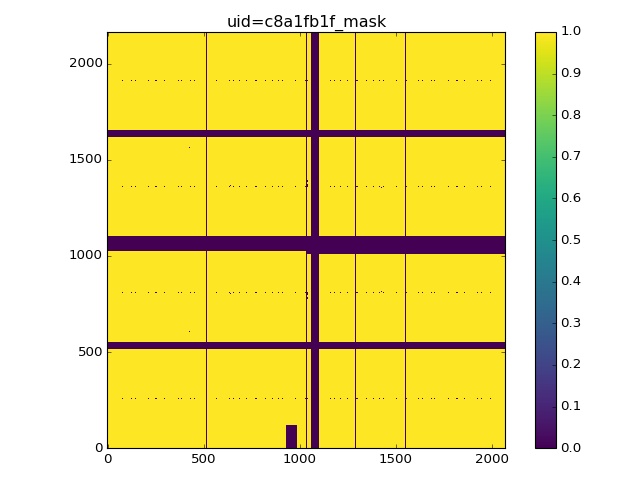

In [16]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse= True ) 
mask =  mask * pixel_mask * Chip_Mask

show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir, aspect=1)
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

<IPython.core.display.Javascript object>


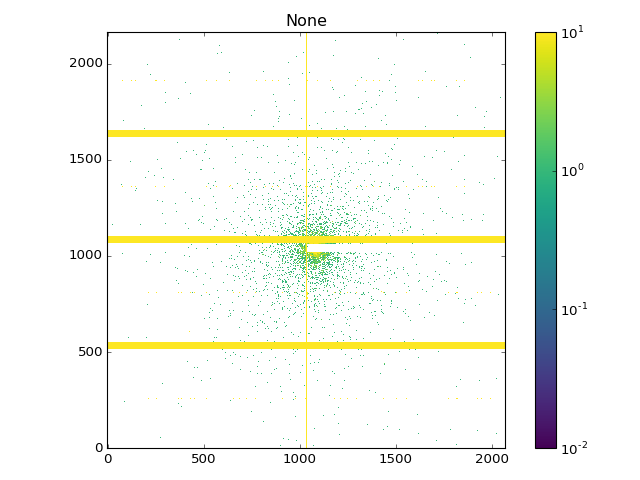

In [18]:
show_img( imgs[40], vmin=.01, vmax= 1e1, logs=True, aspect=1)

# Compress Data

In [19]:
good_start =5 # 5  #5  #make the good_start at least 0 

In [20]:
bin_frame = False #True # False # True  #generally make bin_frame as False
if bin_frame:
    bin_frame_number=4
    timeperframe = acquisition_period * bin_frame_number
else:
    bin_frame_number =1

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_c8a1fb1f-1960-49f8-927a-c29fca8aaafa.cmp.
The good_start frame number is: 5 
uid=c8a1fb1f_fra_5_2000


<IPython.core.display.Javascript object>


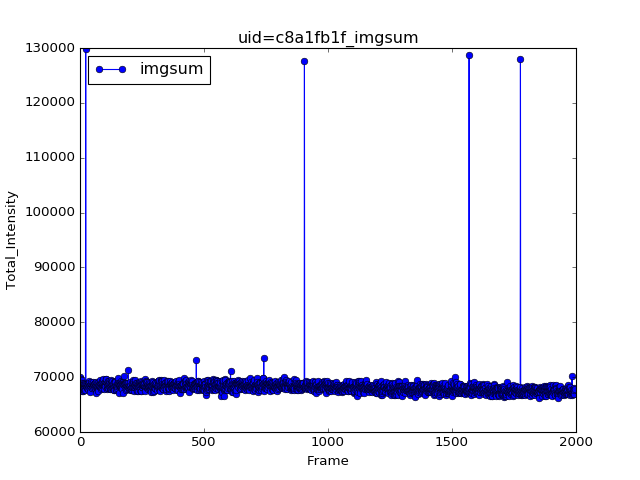

Total time: 0.266 sec


In [21]:
import time
t0= time.time()
if bin_frame_number==1:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%md['uid']
else:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s_bined--%s.cmp'%(md['uid'],bin_frame_number) 
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= force_compress,  para_compress= True,  bad_pixel_threshold = 1e14,
                        bins=bin_frame_number, num_sub= 100, num_max_para_process= 500, with_pickle=True  )
min_inten = 10    
good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
print ('The good_start frame number is: %s '%good_start)

FD = Multifile(filename, good_start, len(imgs)//bin_frame_number)
#FD = Multifile(filename, good_start, 100)
uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
print( uid_ )
plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
       title =uidstr + '_imgsum', xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
Nimg = Nimg/bin_frame_number

run_time(t0)

# Show the average image

<IPython.core.display.Javascript object>


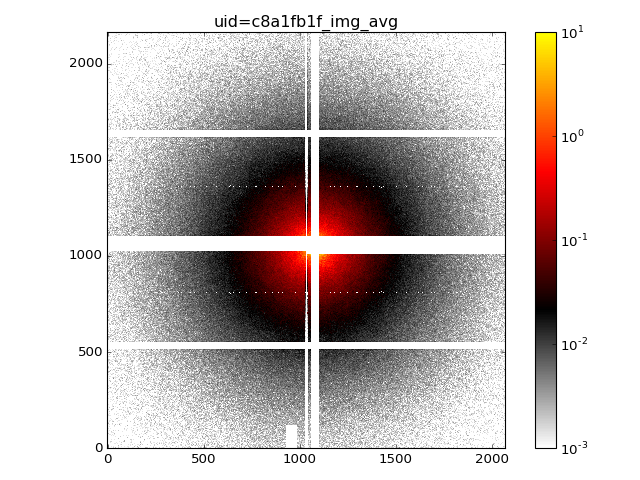

In [22]:
show_img( avg_img,  vmin=.001, vmax= 1e1, logs=True, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula )

# Define ROI Depending on Scattering Geometry

## SAXS Scattering Geometry

<IPython.core.display.Javascript object>


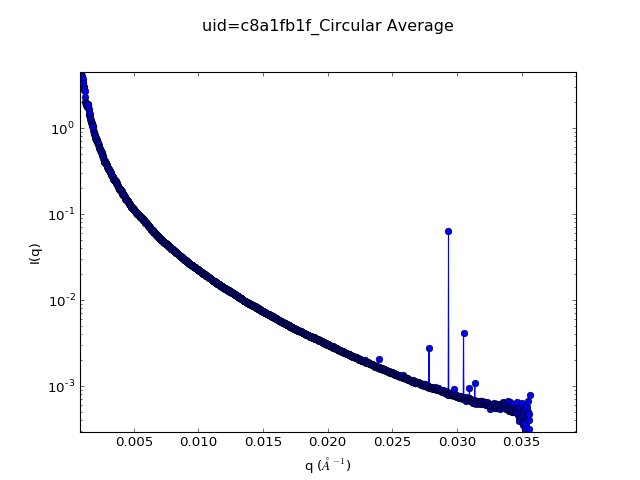

In [23]:
if scat_geometry =='saxs':
    ## Get circular average| * Do plot and save q~iq
    hmask = create_hot_pixel_mask( avg_img, threshold = 1e4, center=center, center_radius= 100)
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, 
                      xlim=[q_saxs.min(), q_saxs.max()*1.1], ylim = [iq_saxs.min(), iq_saxs.max()] )
    mask =np.array( mask * hmask, dtype=bool) 

In [44]:
if scat_geometry =='saxs':    
    uniformq =  True # False    
    ## Define ROI
    #* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
    #* Create ring mask defined by  edges (all in pixel unit)    
    ### Define a non-uniform distributed rings by giving edges
    if not uniformq:    
        width = 0.0001  # in A-1    
        #width = 0.0001
        number_rings= 1         
        qcenters = [   0.0019,  0.0022,
                    0.0025, 0.0028, 0.0031,  0.0034, 0.00365, 0.00395, 0.0042, 0.0045,
                    0.0048, 0.0051, 0.0054, 0.0057 ]#0.00639,0.00754, 0.00880  ] #in A-1        

        qcenters = [ 0.00146, 0.00156, 0.0017,   0.002,  0.0023,
                    0.0028,   0.0034, 0.00365, 0.00395, 
                    0.0048, 0.0050, 0.0052 ]#0.00639,0.00754, 0.00880  ] #in A-1 
            
            
        edges = get_non_uniform_edges(  qcenters, width, number_rings )    
        inner_radius= None
        outer_radius = None
        width = None
        num_rings = None        
    # Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)
    if uniformq:    
        inner_radius= 0.001
        outer_radius = 0.03
        num_rings = 16  #72
        gap_ring_number = 0
        width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
        print(width)
        edges = None

0.0018124999999999999


16


<IPython.core.display.Javascript object>


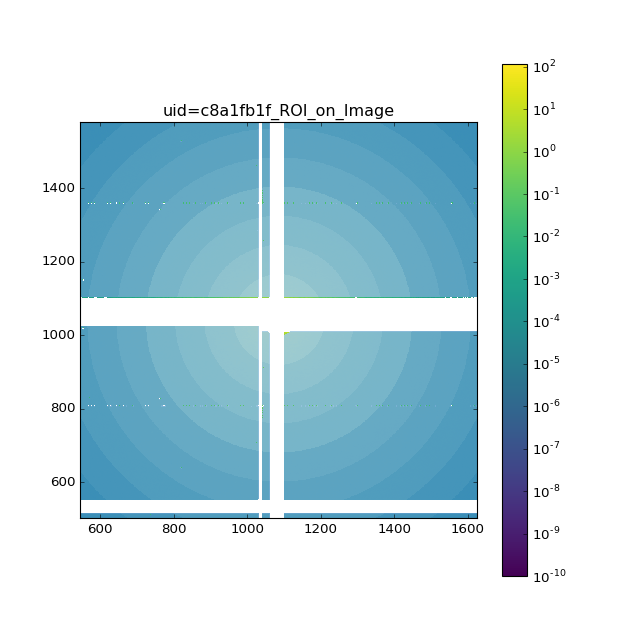

In [45]:
if scat_geometry =='saxs':
    roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
            outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                          unit='A',       pargs=setup_pargs   )
    qind, pixelist = roi.extract_label_indices(  roi_mask  ) 
    qr = np.round( qr, 5)
    print(len(qr))
    show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth = 540, alpha=.9,  
                     save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img), vmax= np.max(avg_img),
                     aspect=1) 
    qval_dict = get_qval_dict( np.round(qr, 5)  ) 

<IPython.core.display.Javascript object>


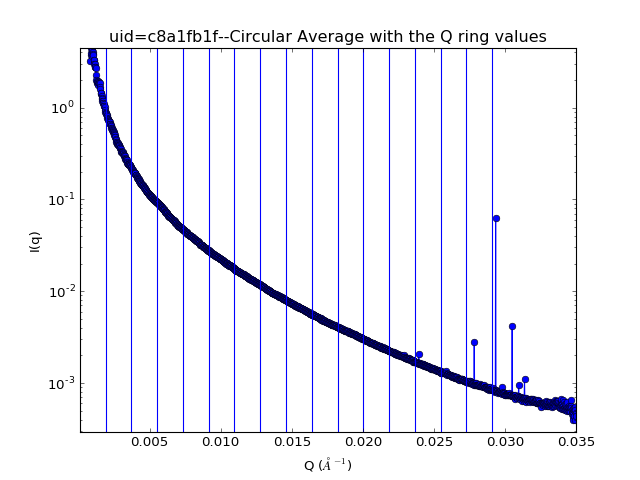

In [46]:
if scat_geometry =='saxs':
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, xlim=[0.0001,0.035],
                  ylim = [iq_saxs.min(), iq_saxs.max()],  save=True, path=data_dir)

# Refine the roi_mask by masking bad pixels

<IPython.core.display.Javascript object>


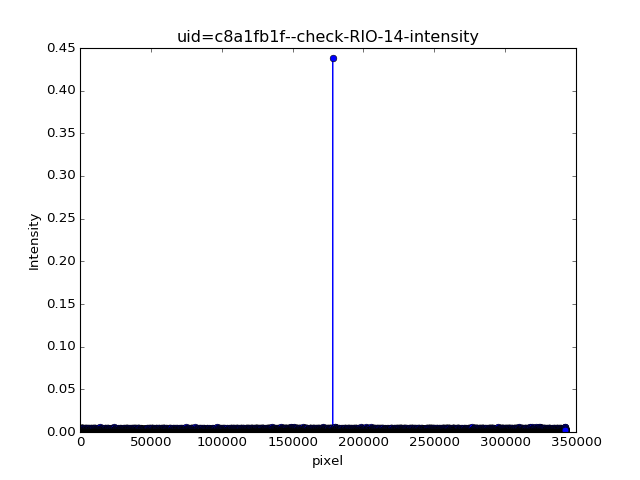

In [47]:
qint = 14
roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qint, uid =uidstr )

In [48]:
if scat_geometry =='saxs':
    filter_badpix_dict ={}
    for k in range(1, len(qr) +1 ):
        roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number=k, uid =uidstr, plot=False )    
        bad_pix_list=  get_bad_frame_list( roi_inten, fit=True, polyfit_order = 30, 
            scale=3.5,  good_start = None, good_end= None, uid= uidstr, path=data_dir, plot=False)
        print( 'The bad frame list length is: %s'%len(bad_pix_list ) )
        filter_badpix_dict[k] = bad_pix_list

/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 241
The bad frame list length is: 481


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 443


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 624


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 705


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 900


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 1358


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 859


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 370


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 529


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 673


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 834


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 4


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 69


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


The bad frame list length is: 2
The bad frame list length is: 1


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


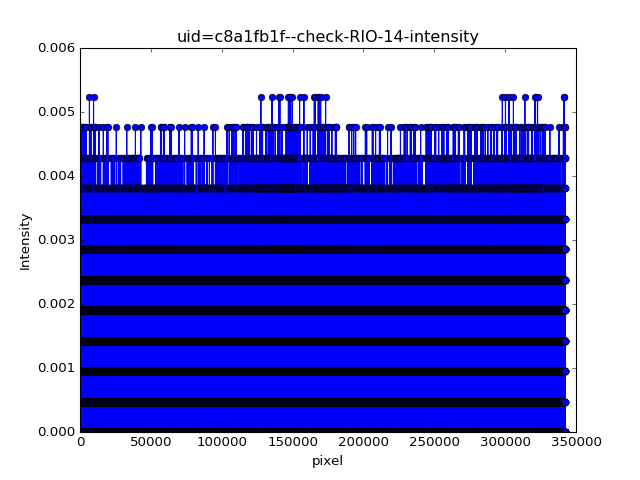

In [49]:
if scat_geometry =='saxs':
    roi_mask = filter_roi_mask( filter_badpix_dict, roi_mask, avg_img, filter_type = 'badpix' )
    roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qint, uid =uidstr )

# WAXS Geometry

In [50]:
def create_ellipse_donut(  cx, cy , wx_inner, wy_inner, wx_outer, wy_outer, roi_mask, gap=0):
    Nmax = np.max( np.unique( roi_mask ) )
    rr1, cc1 = ellipse( cy,cx,  wy_inner, wx_inner  )    
    rr2, cc2 = ellipse( cy, cx,  wy_inner + gap, wx_inner +gap ) 
    rr3, cc3 = ellipse( cy, cx,  wy_outer,wx_outer ) 
    roi_mask[rr3,cc3] = 2 + Nmax
    roi_mask[rr2,cc2] = 0
    roi_mask[rr1,cc1] = 1 + Nmax
    return roi_mask
    
def create_box( cx, cy, wx, wy, roi_mask):
    Nmax = np.max( np.unique( roi_mask ) )
    for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
        x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
        y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
        rr, cc = polygon( y,x)         
        roi_mask[rr,cc] = i +1 + Nmax
    return roi_mask


In [51]:
if scat_geometry =='gi_waxs':
    box_roi = True
    single_box = False   #True, if True, the roi is one box, else, roi is multi-boxes
    ellipse_roi = True
    
    if box_roi:
        if not single_box:
            roi_mask = np.zeros_like( avg_img , dtype = np.int32)
            wx,wy = [20,10]  #each box width and height

            cx = np.int_(np.linspace( 55, 955, 10))  #box center-x        
            nx = len(cx)//2

            y1 = 760-8
            y2=  780-8
            cy1 = np.linspace( y1, y2, nx)
            cy2 = np.linspace( y2, y1, nx)


            cy = np.int_( np.concatenate( [cy1, cy2] ) )  #box-center y

            for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                rr, cc = polygon( y,x)
                #print( i + 1  )
                roi_mask[rr,cc] = i +1
            roi_mask = roi_mask * mask  
            
        else:

            roi_mask = np.zeros_like( avg_img , dtype = np.int32)
            wx,wy = [40,20]  #each box width and height    
            cx, cy = [[ 184, 817, 200, 800], [ 637, 637,200, 200]]     
            cx, cy = [[ 160, 817, 200, 800], [ 650, 637,200, 200]]    
            for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                rr, cc = polygon( y,x)
                #print( i + 1  )
                roi_mask[rr,cc] = i +1

            if False:
                Nmax = np.max( np.unique( roi_mask ) )
                print( Nmax)
                wx,wy = [30,10]  #each box width and height    
                cx, cy = [[ 44, 80], [ 725, 725]]     
                for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                    x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                    y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                    rr, cc = polygon( y,x)
                    #print( i + 1  )
                    roi_mask[rr,cc] = i +1 + Nmax
        
        
    if ellipse_roi ==True:
        #define donut shapes here
        roi_mask = np.zeros_like( avg_img , dtype = np.int32)
        wx1,wy1 = [30,15]  #inner ellipse width and height    
        wx2,wy2 = [80,40]  #outer ellipse width and height 
        gap=5        #gap between two ellipse
        #cx, cy = [[ 184, 817, 200, 800], [ 637, 637,200, 200]] 
        cx, cy = [[ 140, 886, 93, 920], [ 700, 700, 75, 75]]
        
        for i, [x,y] in enumerate(list( zip( cx,cy  ))):  #create ellipse
            roi_mask =  create_ellipse_donut(  x, y , wx1, wy1, 
                                              wx2, wy2, roi_mask, gap=gap)
    #define one box here
    wx,wy = [40,15]  #each box width and height    
    cx, cy = [[ 510], [ 880]]  
    roi_mask = create_box( cx, cy, wx, wy, roi_mask)

        
    roi_mask = roi_mask * mask  
    qind, pixelist = roi.extract_label_indices(roi_mask)
    noqs = len(np.unique(qind))
    qval_dict = get_qval_dict(   1 + np.arange(noqs)   ) 

In [52]:
if scat_geometry =='gi_waxs':
    badpixel = np.where( avg_img[:600,:] >=300 )
    roi_mask[badpixel] = 0
    show_ROI_on_image( avg_img, roi_mask, label_on = True,  alpha=.1,
                 save=True, path=data_dir, uid=uidstr, vmin=0.01, vmax=100, cmap = cmap_albula)

# GiSAXS Scattering Geometry

In [53]:
if scat_geometry =='gi_saxs':
    # Get Q-Map (Qz and Qr)
    ### Users put incident-Beam and Reflection_Beam Centers here!!!
    # Change these lines

    inc_x0 = 1066
    inc_y0 = 372
    refl_x0 = 1066
    refl_y0 = 921
    
    # Don't Change these lines below here
    alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
    qx_map, qy_map, qr_map, qz_map = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )
    ticks_  = get_qzr_map(  qr_map, qz_map, inc_x0, Nzline=10,  Nrline=10   )
    ticks = ticks_[:4]
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks_, data= avg_img, uid= uidstr, path = data_dir   )
    
    

    

## Static Analysis for gisaxs

In [54]:
if scat_geometry =='gi_saxs':
    # For diffuse near Yoneda wing
    qz_start = 0.034
    qz_end = 0.039
    qz_num= 1
    qz_width = 0.005

    qr_start =  0.002
    qr_end = 0.08
    qr_num = 1
    qr_width = 0.08 - 0.002


    Qrs = [qr_start , qr_end, qr_width, qr_num]
    Qzs=  [qz_start,   qz_end,  qz_width , qz_num ]

    # Don't Change these lines below here
    roi_masks, qval_dicts = get_gisaxs_roi( Qrs, Qzs, qr_map, qz_map, mask= mask )
    show_qzr_roi( avg_img, roi_masks, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )


## Dynamic Analysis for gi_saxs

In [55]:
if scat_geometry =='gi_saxs':
    # Define Q-ROI
    #* Users provide the interested Qz and Qr here for XPCS analysis, e.g., qr start/end/number/width et.al
    # Change these lines
    
    qz_start = 0.025
    qz_end = 0.035
    qz_num= 1
    gap_qz_num = 1
    qz_width = (qz_end - qz_start)/(qz_num +gap_qz_num)
    
    qr_start =  0.005
    qr_end = 0.055
    qr_num = 9
    gap_qr_num = 1
    qr_width = ( qr_end- qr_start)/(qr_num+gap_qr_num)


    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]
    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )


In [56]:
if scat_geometry =='gi_saxs':
    ### Change the below lines to if define another ROI, if define even more, just repeat this process
    define_second_roi = False  #if True to define another line; else: make it False
    if define_second_roi:    
        qval_dict1 = qval_dict.copy()
        roi_mask1 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Second ROI
    if define_second_roi:    
        qz_start2 = 0.044
        qz_end2 = 0.05
        qz_num2= 1
        gap_qz_num2 = 1
        qz_width2 = 0.005 #(qz_end2 - qz_start2)/(qz_num2 +gap_qz_num2)    
        
        qr_start2 =  -0.003
        qr_end2 = 0.003
        qr_num2 = 1
        gap_qr_num2 = 5
        qr_width2 = 0.006 #( qr_end2- qr_start2)/(qr_num2+gap_qr_num2)        
        
        Qr2 = [qr_start2 , qr_end2, qr_width2, qr_num2]
        Qz2=  [qz_start2,   qz_end2,  qz_width2 , qz_num2 ] 
        roi_mask2, qval_dict2 = get_gisaxs_roi( Qr2, Qz2, qr_map, qz_map, mask= mask )
        
        qval_dict = update_qval_dict(  qval_dict1, qval_dict2 )
        roi_mask = update_roi_mask(  roi_mask1, roi_mask2 )  
        
    show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )        
    ## Get 1D Curve (Q||-intensity¶)
    qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, inc_x0= None, setup_pargs=setup_pargs )
    plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=False, save=True, uid=uidstr, path = data_dir)

In [57]:
 data_dir0

'/XF11ID/analysis/CHX_Results_Pipelines/Beamline_Paper/Results/'

In [58]:

#fp = data_dir0 + 'uid=%s_roi_16m.pkl'%uid
#fp = data_dir0 + 'SiO2_250nm_roi_16m_4M.pkl'

#fp = data_dir0 + 'SiO2_500nm_roi_16m.pkl'
#fp = data_dir0 + 'rub_roi_16m.pkl'

#fp = data_dir0 + 'Au15_roi_16m_4M.pkl'
#fp = data_dir0 + 'Au15_roi_16m_4M_dose.pkl'

fp = data_dir0 + 'Au15_roi_16m_4M.pkl'
#fp = data_dir0 + 'SiO2_500nm_roi_16m_4M.pkl'
print( fp )
cpk.dump( [roi_mask,qval_dict],  open(fp, 'wb' ) )

fp = data_dir0 + 'uid=%s_roi_16m.pkl'%uid
print(fp)
cpk.dump( [roi_mask,qval_dict],  open(fp, 'wb' ) )
#roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data


/XF11ID/analysis/CHX_Results_Pipelines/Beamline_Paper/Results/Au15_roi_16m_4M.pkl
/XF11ID/analysis/CHX_Results_Pipelines/Beamline_Paper/Results/uid=c8a1fb1f_roi_16m.pkl


In [59]:
if scat_geometry == 'gi_saxs':
    fp = data_dir0 + 'gisaxs_test.pkl' #dump qr_map, qz_map, ticks_, Qrs, Qzs, Qr, Qz, inc_x0
    cpk.dump( [qr_map, qz_map, ticks_, Qrs, Qzs, Qr, Qz, inc_x0 ],  open(fp, 'wb' ) )

    

In [60]:
uid

'c8a1fb1f'